#**Problem 1 Bengali Handwritten Digits**

The English handwritten digit recognition is one of the most popular problems in machine learning and computer vision. This problem is solved using various techniques. In this assignment, we will classify Bengali Handwritten Digits using logistic regression.
 
Handwritten Digits classification can be used in various applications like optical character recognition, restore text from old documents, etc.
In this assignment our main goal will be to achieve a good result using logistic regression and tuning hyperparameters correctly to get a better result.
 




#**Dataset**


> For this experiment, we will use the dataset [NumtaDB](https://www.kaggle.com/BengaliAI/numta/) which is available in **Kaggle**. 
There will be a total of **54908** images, and it was split in a **90:10** ratio. **90%** (**49417**) of data is used in training and **10%** (**5491**) was used in testing.

#Snapshot of Dataset

> <div align="center">
<img src="https://drive.google.com/uc?id=1LvkNwV1My2RniR_JsbasBET1fa97eMQu" width="500">
</div>

#**Experimental Setup**


> All of these experiments were performed using Google Colab free GPU, Models were created in PyTorch. 


During the whole experiment,
* The height and width of the input was **28*28 =784** 
* Output dimension was **(০,১,২,৩,৪,৫,৬,৭,৮,৯)=10**
* Each batch size was different if each setting
* The number of iteration was **15000**
* Different activation function was used 
* GPU **Tesla T4** was availabe
* Number of Epochs was different if each setting

- **totaldata:** 54908
  - $epochs = iterations \div \frac{totaldata}{minibatch}  $

We will use different learning rate to achieve better performance

# **Result**


| Experiment Number      | Optimizer     | Learning Rate     |  Num of Hidden Layer   | Btach Size |Num of epoch    | |  Accurecy of last 1000 iterations    |
| :------------- | :----------: |:----------: | :-----------: | :-----------:  | :-----------: || :-----------: |
|  1 |SGD   | 0.09 | 4| 128 | 38   ||72.93  |
|  2 |SGD   | 0.5 | 4| 256 | 77   ||77.52  |
|  3 |SGD   | 0.11 | 4| 128 | 38   ||76.12  |
|  4 |SGD   | 0.04 | 4| 512 | 155   ||80.84  |







**Download Dataset Direct From Kaggle**

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


**Importing All Important Library**

In [ ]:
import os 
import zipfile 
import matplotlib.pyplot as plt
import pandas as pd
import shutil 
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from PIL import *
from torch.utils.data import Dataset
print(torch.cuda.get_device_name())

Tesla T4


**Download Kaggle Dataset**

In [ ]:
!kaggle datasets download -d BengaliAI/numta

100% 1.91G/1.91G [00:18<00:00, 34.0MB/s]
100% 1.91G/1.91G [00:18<00:00, 111MB/s] 


**Unzip Dataset and Create new local Directory**

In [ ]:
local_dir='/content/numta.zip'
zip_ref=zipfile.ZipFile(local_dir,'r')
extract_loc='/tmp'
zip_ref.extractall(extract_loc)
zip_ref.close
TRAIN_PATH="/tmp/train"
os.mkdir(TRAIN_PATH)


**Function For Copying Image and Merging CSV**

In [ ]:
def copy_image(src,ls):
  for image in ls:
    file_name = os.path.join(src, image)
    if os.path.isfile(file_name):
      shutil.copy(file_name, TRAIN_PATH)  
def merge_csv(path,col_list):
  df=pd.read_csv(path,usecols=col_list)
  merged_csv_new = pd.concat(df)      

**Reading and Merging CSV**

In [ ]:
col_list = ["filename", "digit"]
folder=os.listdir(extract_loc)
csv_name=[]
for files in folder:
  if files.endswith(".csv")  and not files.startswith("training-b") and not files.startswith("training-e"):
    path=extract_loc+"/"+files
    df=pd.read_csv(path,usecols=col_list)
    csv_name.append(df)
merged_csv = pd.concat(csv_name,ignore_index=True) 

**Copying Image**

In [ ]:
folder=os.listdir(extract_loc)
for files in folder:
  if files.startswith("training") and not files.endswith(".csv") and not files.startswith("training-b") and not files.startswith("training-e") :
    path=extract_loc+"/"+files
    src = path + '/'
    copy_image(src,os.listdir(path))
 

**Function For Dataset Preparation**

In [ ]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

dataset  = Dataset(merged_csv, TRAIN_PATH, train_transform)





**Displaying Image and Label**

Trainig label:  3


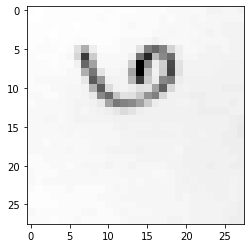

In [ ]:
show_img = dataset[1][0].numpy().reshape(28, 28)
plt.imshow(show_img, cmap='gray')
print("Trainig label: ",dataset[1][1])

**Train and Test Data Split**

In [ ]:
train_dataset, test_dataset = train_test_split(dataset, test_size = 0.1)

**1**

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

# Hyperparameters
batch_size = 128
num_iters = 15000
input_dim = 28*28 # num_features = 784
#num_hidden = 100
output_dim = 10

learning_rate = 0.09

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")




num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 

class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 128
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.SELU()

        ### 2nd hidden layer: 128 --> 128
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 =  nn.SELU()

        ### 3rd hidden layer: 128 --> 128
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 =  nn.SELU()


        ### 4th hidden layer: 128 --> 128
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 4th hidden layer
        self.relu_4 =  nn.SELU()

        ### Output layer: 128 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)
        
        ### 4th hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 4th hidden layer
        out = self.relu_4(out)

        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = 128)
# To enable GPU
model.to(device)

# INSTANTIATE LOSS & OPTIMIZER CLASS

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 2.1579363346099854. Accuracy: 28.41012566017119
Iteration: 2000. Loss: 1.9997174739837646. Accuracy: 33.80076488799854
Iteration: 3000. Loss: 2.1141440868377686. Accuracy: 33.70970679293389
Iteration: 4000. Loss: 1.987943172454834. Accuracy: 32.12529593880896
Iteration: 5000. Loss: 1.7649571895599365. Accuracy: 37.9894372609725
Iteration: 6000. Loss: 1.3171846866607666. Accuracy: 54.74412675286833
Iteration: 7000. Loss: 1.7650419473648071. Accuracy: 49.20779457293754
Iteration: 8000. Loss: 1.2184234857559204. Accuracy: 47.4412675286833
Iteration: 9000. Loss: 1.0898027420043945. Accuracy: 65.015479876161
Iteration: 10000. Loss: 0.956459641456604. Accuracy: 72.13622291021672
Iteration: 11000. Loss: 0.926159143447876. Accuracy: 65.05190311418686
Iteration: 12000. Loss: 2.1487927436828613. Accuracy: 44.87342924786014
Iteration: 13000. Loss: 0.7554488182067871. Accuracy: 77.52686213804407
Iteration: 14000. Loss: 0.7926562428474426. Accuracy: 72.93753414678565


**2**

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

# Hyperparameters
batch_size = 256
num_iters = 15000
input_dim = 28*28 # num_features = 784
#num_hidden = 100
output_dim = 10

learning_rate = 0.05

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")




num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 

class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 128
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.selu_1 = nn.SELU()

        ### 2nd hidden layer: 128 --> 128
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.selu_2 = nn.SELU()

        ### 3rd hidden layer: 128 --> 128
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.selu_3 = nn.SELU()


        ### 4th hidden layer: 128 --> 128
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 4th hidden layer
        self.selu_4 = nn.SELU()

        ### Output layer: 128 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.selu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.selu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.selu_3(out)
        
        ### 4th hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 4th hidden layer
        out = self.selu_4(out)

        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = 128)
# To enable GPU
model.to(device)

# INSTANTIATE LOSS & OPTIMIZER CLASS

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 2.224569320678711. Accuracy: 25.805864141322164
Iteration: 2000. Loss: 2.0187759399414062. Accuracy: 34.49280641048989
Iteration: 3000. Loss: 2.0802016258239746. Accuracy: 25.186669094882536
Iteration: 4000. Loss: 1.9835275411605835. Accuracy: 47.42305590967037
Iteration: 5000. Loss: 1.51662015914917. Accuracy: 40.79402658896376
Iteration: 6000. Loss: 1.436682939529419. Accuracy: 57.803678747040614
Iteration: 7000. Loss: 1.3447190523147583. Accuracy: 56.98415589145875
Iteration: 8000. Loss: 1.346251130104065. Accuracy: 63.1578947368421
Iteration: 9000. Loss: 1.2655143737792969. Accuracy: 51.975960662902935
Iteration: 10000. Loss: 1.0630393028259277. Accuracy: 60.8085958841741
Iteration: 11000. Loss: 1.0911773443222046. Accuracy: 67.14623930067383
Iteration: 12000. Loss: 0.7364404797554016. Accuracy: 71.95410672008741
Iteration: 13000. Loss: 1.1693074703216553. Accuracy: 68.94918958295392
Iteration: 14000. Loss: 0.5972887873649597. Accuracy: 77.52686213804407


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

# Hyperparameters
batch_size = 128
num_iters = 15000
input_dim = 28*28 # num_features = 784
#num_hidden = 100
output_dim = 10

learning_rate = 0.11

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")




num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 

class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 128
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.selu_1 = nn.SELU()

        ### 2nd hidden layer: 128 --> 128
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.selu_2 = nn.SELU()

        ### 3rd hidden layer: 128 --> 128
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.selu_3 = nn.SELU()


        ### 4th hidden layer: 128 --> 128
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 4th hidden layer
        self.selu_4 = nn.SELU()

        ### Output layer: 128 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.selu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.selu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.selu_3(out)
        
        ### 4th hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 4th hidden layer
        out = self.selu_4(out)

        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = 128)
# To enable GPU
model.to(device)

# INSTANTIATE LOSS & OPTIMIZER CLASS

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 2.3162107467651367. Accuracy: 20.36059005645602
Iteration: 2000. Loss: 2.027053117752075. Accuracy: 23.238025860498997
Iteration: 3000. Loss: 2.045153856277466. Accuracy: 26.86213804407212
Iteration: 4000. Loss: 2.054659843444824. Accuracy: 21.14368967401202
Iteration: 5000. Loss: 1.8202632665634155. Accuracy: 49.64487342924786
Iteration: 6000. Loss: 1.9556227922439575. Accuracy: 42.57876525223092
Iteration: 7000. Loss: 1.4245911836624146. Accuracy: 46.63995629211437
Iteration: 8000. Loss: 1.30168879032135. Accuracy: 47.6780185758514
Iteration: 9000. Loss: 1.0297679901123047. Accuracy: 67.47404844290658
Iteration: 10000. Loss: 1.1112946271896362. Accuracy: 62.81187397559643
Iteration: 11000. Loss: 0.900826632976532. Accuracy: 66.49062101620834
Iteration: 12000. Loss: 0.8133956789970398. Accuracy: 64.70588235294117
Iteration: 13000. Loss: 0.654862105846405. Accuracy: 69.33163358222546
Iteration: 14000. Loss: 0.5419927835464478. Accuracy: 76.12456747404845


**4**

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

# Hyperparameters
batch_size = 512
num_iters = 15000
input_dim = 28*28 # num_features = 784
#num_hidden = 100
output_dim = 10

learning_rate = 0.04

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")




num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 

class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 128
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.selu_1 = nn.SELU()

        ### 2nd hidden layer: 128 --> 128
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.selu_2 = nn.SELU()

        ### 3rd hidden layer: 128 --> 128
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.selu_3 = nn.SELU()


        ### 4th hidden layer: 128 --> 128
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 4th hidden layer
        self.selu_4 = nn.SELU()

        ### Output layer: 128 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.selu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.selu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.selu_3(out)
        
        ### 4th hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 4th hidden layer
        out = self.selu_4(out)

        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = 128)
# To enable GPU
model.to(device)

# INSTANTIATE LOSS & OPTIMIZER CLASS

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 2.141386032104492. Accuracy: 27.080677472227283
Iteration: 2000. Loss: 1.8769338130950928. Accuracy: 36.113640502640685
Iteration: 3000. Loss: 1.875001072883606. Accuracy: 44.782371152795484
Iteration: 4000. Loss: 1.7680174112319946. Accuracy: 49.51739209615735
Iteration: 5000. Loss: 1.400335431098938. Accuracy: 50.31870333272628
Iteration: 6000. Loss: 1.272104024887085. Accuracy: 51.64815152067019
Iteration: 7000. Loss: 1.2456040382385254. Accuracy: 62.90293207066108
Iteration: 8000. Loss: 1.0494322776794434. Accuracy: 58.44108541249317
Iteration: 9000. Loss: 0.9516683220863342. Accuracy: 68.34820615552722
Iteration: 10000. Loss: 0.8527882099151611. Accuracy: 72.66435986159169
Iteration: 11000. Loss: 0.8400475382804871. Accuracy: 70.33327262793662
Iteration: 12000. Loss: 0.7506067752838135. Accuracy: 76.37953014022946
Iteration: 13000. Loss: 0.6592952013015747. Accuracy: 75.83318156984156
Iteration: 14000. Loss: 0.5661241412162781. Accuracy: 81.58805317792752
It

In [ ]:
num_epochs = num_iters / (len(train_dataset) / 512)
num_epochs = int(num_epochs)
num_epochs

155